### Critical windows with the causal RF: Analysis Phase 3
- The objective of this analysis phase it to perform tests which incorporate correlation between exposure over time. The causal RF may have greater difficulty recovering the effect of correlated exposures.  
- All models use a random draw of 5000 exposure profiles from the cohort's actual exposure profiles, with an outcome based on actual birth weight mean and df. One exposure is confounding the critical exposure(s).   

**Model 3.A:** a naive critical window  
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is naive, with equal (i.e., constant) effects  

**Model 3.B:** a time-varying critical window  
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is time-varying, with larger effects around a peak (e.g., high in weeks 2, 4; peak in week 3)  

**Model 3.C:** a concentrated critical exposure  
- 6 exposures: 1 critical, 4 not critical, 1 confounder on critical exposure  
- the exposure effect is concentrated (e.g., in week 3); i.e., the full effect of CW in model 1.C is concentrated in a single exposure  

In [50]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from econml.dml import LinearDML
from econml.dml import CausalForestDML

np.set_printoptions(suppress=True)

In [51]:
np.random.seed(1004) # use throughout

Cohort information
Get the mean and SD for ozone exposure and birth weight.

In [52]:
births = pd.read_csv("data/birth_clean_wide.csv")
births_long = pd.read_csv("data/birth_clean_long.csv")

o3_mean = births_long['max_o3'].mean()
o3_sd = births_long['max_o3'].std()

bw_mean = births["birthweightgrams"].mean()
bw_sd = births["birthweightgrams"].std()


#### Model 1.A
20 successive exposures: 3 critical, others not critical, 1 confounder on critical exposures

##### "Data"
A few conventions: `T` is treatments, `W` is confounders (aka controls), and `X` is features (includes confounders and covariates, but not treatment). For all models in this project, `X = W`, as there are no covariates, only confounders.

In [53]:
np.random.seed(1007)

n_samples = 5000 # 5000

n_X = 1
n_T = 20 # one critical, two not
n_W = 1 # one confounder

# features (in this case, confounders); z-scaled
X = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
# treatments / exposures; z-scaled
T_sample = births.sample(n = n_samples, replace = False)

T_1 = (T_sample['max_o3_01'] - o3_mean) / o3_sd
T_2 = (T_sample['max_o3_02'] - o3_mean) / o3_sd
T_3 = (T_sample['max_o3_03'] - o3_mean) / o3_sd
T_4 = (T_sample['max_o3_04'] - o3_mean) / o3_sd
T_5 = (T_sample['max_o3_05'] - o3_mean) / o3_sd
T_6 = (T_sample['max_o3_06'] - o3_mean) / o3_sd
T_7 = (T_sample['max_o3_07'] - o3_mean) / o3_sd
T_8 = (T_sample['max_o3_08'] - o3_mean) / o3_sd
T_9 = (T_sample['max_o3_09'] - o3_mean) / o3_sd
T_10 = (T_sample['max_o3_10'] - o3_mean) / o3_sd
T_11 = (T_sample['max_o3_11'] - o3_mean) / o3_sd
T_12 = (T_sample['max_o3_12'] - o3_mean) / o3_sd
T_13 = (T_sample['max_o3_13'] - o3_mean) / o3_sd
T_14 = (T_sample['max_o3_14'] - o3_mean) / o3_sd
T_15 = (T_sample['max_o3_15'] - o3_mean) / o3_sd
T_16 = (T_sample['max_o3_16'] - o3_mean) / o3_sd
T_17 = (T_sample['max_o3_17'] - o3_mean) / o3_sd
T_18 = (T_sample['max_o3_18'] - o3_mean) / o3_sd
T_19 = (T_sample['max_o3_19'] - o3_mean) / o3_sd
T_20 = (T_sample['max_o3_20'] - o3_mean) / o3_sd


Look at correlation

In [54]:
T_vars = np.vstack((T_1, T_2, T_3, T_4, T_5,
                    T_6, T_7, T_8, T_9, T_10,
                    T_11, T_12, T_13, T_14, T_15,
                    T_16, T_17, T_18, T_19, T_20))
correlation_matrix = np.corrcoef(T_vars)
# print(correlation_matrix_np)

# correlation_matrix = T_vars.corr(numeric_only=True)

# plt.figure(figsize=(8, 6)) # Adjust figure size as needed
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5,
#             annot_kws={"size": 7})
# plt.title('Correlation Matrix Heatmap')
# plt.show()


Adjust the confounder so it is related to one treatment.

In [55]:
np.random.seed(1004)

## Confounder coefficient
b_W0T9 = 2.5
b_W0T10 = 2.5
b_W0T11 = 2.5
X = b_W0T9 * T_9 + b_W0T10 * T_10 + b_W0T11 * T_11 + np.random.normal(size=n_samples)
# z scale
X = X / X.std()
X = X.to_numpy()

# a 2.5-unit increase in the confounder increases the exposure by 1 unit
# this is done backwards (tx causes confounder) because later on, we'll use a real tx and synthetic confounder

(array([   6.,   78.,  298.,  788., 1374., 1278.,  839.,  268.,   64.,
           7.]),
 array([-3.60819563, -2.88298797, -2.15778031, -1.43257265, -0.707365  ,
         0.01784266,  0.74305032,  1.46825798,  2.19346563,  2.91867329,
         3.64388095]),
 <BarContainer object of 10 artists>)

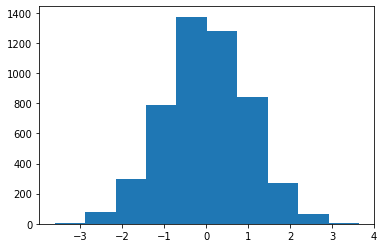

In [56]:
# plt.hist(b_W0T9 * T_9 + b_W0T10 * T_10 + b_W0T11 * T_11,alpha = 0.5)
# plt.hist(b_W0T9 * T_9 + b_W0T10 * T_10 + b_W0T11 * T_11 + np.random.normal(size=n_samples), alpha = 0.5)
plt.hist(np.random.normal(size=n_samples))

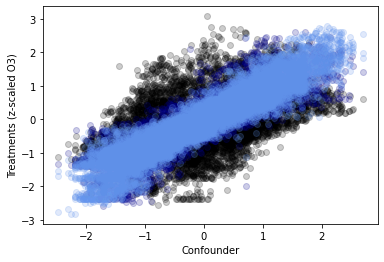

In [57]:
plt.plot(X, T_1, 'o', alpha = 0.2, color = "black") # one example of unconfounded, noncritical tx
plt.plot(X, T_8, 'o', alpha = 0.2, color = "darkblue") # one example of unconfounded, noncritical tx
plt.plot(X, T_9, 'o', alpha = 0.2, color = "cornflowerblue") # confounded, critical tx
plt.plot(X, T_10, 'o', alpha = 0.2, color = "cornflowerblue") # confounded, critical tx
plt.plot(X, T_11, 'o', alpha = 0.2, color = "cornflowerblue") # confounded, critical tx
plt.xlabel("Confounder")
plt.ylabel("Treatments (z-scaled O3)")
plt.show()

Create the critical window coefficients

In [58]:
study_period = np.linspace(1, 20, 20)
effect_size = -166 # lower threshold: 166; middle: 200-517; upper: 647
# the window should be 9 wide, then 7 wide, then 3 wide
window_start = 6
window_center = 10
window_end = 14

uni_pdf = stats.Uniform(a = window_start, b = window_end)
uni_wide_fx  = uni_pdf.pdf(study_period) * effect_size

uni_pdf = stats.Uniform(a = window_start + 1, b = window_end - 1)
uni_moderate_fx  = uni_pdf.pdf(study_period) * effect_size

uni_pdf = stats.Uniform(a = window_start + 3, b = window_end - 3)
uni_narrow_fx  = uni_pdf.pdf(study_period) * effect_size

norm_pdf = stats.norm.pdf(study_period, window_center, 2.5)
norm_wide_fx  = norm_pdf * effect_size 

norm_pdf = stats.norm.pdf(study_period, window_center, 1)
norm_moderate_fx  = norm_pdf * effect_size 

norm_pdf = stats.norm.pdf(study_period, window_center, 0.5)
norm_narrow_fx = norm_pdf * effect_size 

In [59]:
# get a list of treatment variables, to assign to coefficients
week_list = list(map(str, np.arange(1, 21)))
week_list = [str(num).zfill(2) for num in week_list]

T_vars_names = list(map(lambda item: "T_" + item, week_list))

In [60]:
# # # y = [sum(fx) + b_int + b_W0y for fx in zip(*tx_fx_list)]
# tx_fx, tx = norm_narrow_fx, T_vars
# tx_fx_list = [tx[i] * tx_fx[i] for i in np.arange(0, 20)]
# tx_total = [sum(fx) for fx in zip(*tx_fx_list)]
# wx_total = X * b_W0y
# # # pd.concat([wx_total, wx_total])
# total = bw_mean + -sum(norm_narrow_fx) * 4.25 + tx_total + wx_total
# # # wx_total = [sum(fx) for fx in zip(*wx_fx_list)]
# # # y = [sum(fx) for fx in zip(*total)]
# plt.hist(total, bins = 30)
# # # b_W0y * X

# # # # ) + b_int

# # total


Create the outcome using PDFs

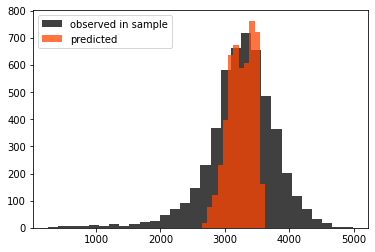

bw mean: 3260.2554276717005
y-hat mean 3248.899443550296
bw sd: 536.5732455330558
y-hat sd 198.4254932470636


In [61]:
# the coefficients and treatment variables
tx_fx, tx = norm_moderate_fx, T_vars
# the vectors of each coefficient * treatment variable
tx_fx_list = [tx[i] * tx_fx[i] for i in np.arange(0, 20)]
# tx_fx_list = [tx[10] * tx_fx[10]]
# total treatment effect by individual
total_tx_fx = [sum(fx) for fx in zip(*tx_fx_list)]

# the confounder effect (z-scaled, see above)
b_W0y = -50
# the vector of confounder effects
wx_fx = X * b_W0y

# bit of noise
e = np.random.normal(size=n_samples, loc = 0, scale = 10)

# intercept, with a bit of noise, plus the total effect of exposure * 4, to keep central tendency
b_int = bw_mean
# b_int = np.random.normal(size = n_samples, loc = bw_mean, scale = 25) # 50

#np.random.normal(size=n_samples, loc = bw_mean, scale = bw_sd) + -sum(norm_narrow_fx)

# interaction effect
b_intx = -25
intx_fx = b_intx * tx[8] * tx[9] #[b_intx * tx[i] for i in np.arange(8, 10)]

y = b_int + total_tx_fx + wx_fx + e + intx_fx


plt.hist(T_sample["birthweightgrams"], bins = 30,
         alpha = 0.75,# edgecolor = "white", 
         color = "black",
         label = "observed in sample")
plt.hist(y, bins = 12, alpha = 0.75,
         #edgecolor = "white",
         color = "orangered", 
         label = "predicted")
plt.legend(loc = 'upper left')
plt.show()

print("bw mean:", bw_mean)
print("y-hat mean", sum(y) / len(y))
print("bw sd:", bw_sd)
print("y-hat sd", np.std(y))

In [62]:
# plt.plot(snr["e_var"], snr["y_hat_std"])
# plt.xlim(0, 175)
# plt.ylim(175, (200+175))
# plt.xlabel("Standard deviation of random error")
# plt.ylabel("Standard deviation in y_hat")

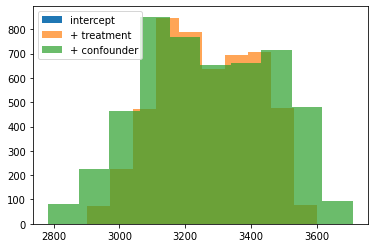

In [63]:
# in case we want to see how the distribution changes with tx, wx
plt.hist(b_int, label = "intercept")
plt.hist(b_int + total_tx_fx, alpha = 0.7, label = "+ treatment")
plt.hist(b_int + total_tx_fx + wx_fx, alpha = 0.7, label = "+ confounder")
plt.legend(loc = "upper left")

deprecated: Create the outcome

In [64]:
# ## Coefficients
# b_int = bw_mean + 500 # bw_mean for baseline, plus enough to make the predicted mean = bw_mean

# tx_fx, tx = norm_moderate_fx, T_vars

# b_T9y = -70 # should have no effect
# b_T10y = -70 # the critical exposure decreases bw by 70 g per one-sd increase
# b_T11y = -70 # should have no effect
# b_W0y = -35 # the confounder also decreases bw by 35 g per one-sd increase

# y = b_int + b_T9y * T_9 + b_T10y * T_10 + b_T11y * T_11 + b_W0y * X

# # bw_mean = births["birthweightgrams"].mean()
# # bw_sd = births["birthweightgrams"].std()


In [65]:
# plt.hist(y, bins = 30, edgecolor = "white")
# print(bw_mean)
# print(y.mean()) # this is about right
# print(bw_sd)
# y.std() # fairly close

Correlation between exposures, outcome

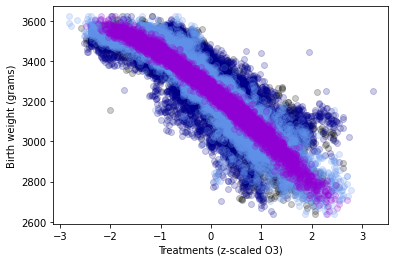

In [66]:
plt.plot(T_8, y, 'o', alpha = 0.2, color = "black") # noncritical tx in black
plt.plot(T_15, y, 'o', alpha = 0.2, color = "darkblue") # noncritical tx in black
plt.plot(T_9, y, 'o', alpha = 0.2, color = "cornflowerblue") # critical tx in blue
plt.plot(T_10, y, 'o', alpha = 0.2, color = "cornflowerblue") # critical tx in blue
plt.plot(T_11, y, 'o', alpha = 0.2, color = "cornflowerblue") # critical tx in blue
plt.plot(X, y, 'o', alpha = 0.2, color = "darkviolet") # confounder in violet
plt.xlabel("Treatments (z-scaled O3)")
plt.ylabel("Birth weight (grams)")
plt.show()

Matrix for treatments, confounders

In [67]:
T = pd.DataFrame({'noncritical_tx_1': T_1, 'noncritical_tx_2': T_2, 
                  'noncritical_tx_3': T_3, 'noncritical_tx_4': T_4, 
                  'noncritical_tx_5': T_5, 'noncritical_tx_6': T_6, 
                  'noncritical_tx_7': T_7, 'critical_tx_8': T_8, 
                  'critical_tx_9': T_9, 'critical_tx_10': T_10,
                  'critical_tx_11': T_11, 'critical_tx_12': T_12, 
                  'noncritical_tx_13': T_13, 'noncritical_tx_14': T_14, 
                  'noncritical_tx_15': T_15, 'noncritical_tx_16': T_16, 
                  'noncritical_tx_17': T_17, 'noncritical_tx_18': T_18, 
                  'noncritical_tx_19': T_19, 'noncritical_tx_20': T_20#,
                #   'weeks9_and_10': tx[8] * tx[9]
                  })
X = pd.DataFrame(X, columns=['confounder'])
# X = pd.DataFrame({'gestation': T_sample['gestation']})
# y = pd.DataFrame({'birthweight': y})

##### Causal RF  

In [49]:
est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      n_estimators=500)

est.fit(y, T=T, X=X, W=X)
# takes 20-40 seconds w/ 5000
# takes 50-65 seconds w/ 10000

Extract the marginal effects

In [192]:
est.marginal_ate_inference(T, X)
# takes 20-30 seconds

,mean_point,stderr_mean,zstat,pvalue,ci_mean_lower,ci_mean_upper
T0,-0.687,5.297,-0.13,0.897,-11.07,9.695
T1,0.673,5.056,0.133,0.894,-9.236,10.582
T2,-1.475,4.853,-0.304,0.761,-10.987,8.036
T3,0.211,4.74,0.044,0.965,-9.079,9.501
T4,0.643,4.897,0.131,0.895,-8.955,10.242
T5,-0.105,5.213,-0.02,0.984,-10.323,10.112
T6,-0.756,5.134,-0.147,0.883,-10.818,9.306
T7,-9.289,5.114,-1.816,0.069,-19.312,0.734
T8,-38.382,6.348,-6.046,0.0,-50.824,-25.941
T9,-65.65,6.308,-10.408,0.0,-78.013,-53.286


Feature importance 

In [224]:
dir(est.feature_importances())
est.feature_importances()

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__buffer__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '

In [180]:
# Extract all values once (avoiding redundant calls)
treatments = np.array(est.cate_treatment_names())
means = np.array(est.marginal_ate(T, X))
ci_lower, ci_upper = est.marginal_ate_interval(T, X)

# Construct DataFrame directly
res_df = pd.DataFrame({
    'treatment': treatments,
    'mean': means,
    'ci_lower': ci_lower,
    'ci_upper': ci_upper
})

res_df

,treatment,mean,ci_lower,ci_upper
0,noncritical_tx_1,-0.687347,-11.069809,9.695115
1,noncritical_tx_2,0.672590,-9.236422,10.581601
2,noncritical_tx_3,-1.475434,-10.987300,8.036433
3,noncritical_tx_4,0.210826,-9.079220,9.500873
4,noncritical_tx_5,0.643285,-8.955117,10.241686
5,noncritical_tx_6,-0.105111,-10.322665,10.112443
6,noncritical_tx_7,-0.756134,-10.818185,9.305918
7,critical_tx_8,-9.288676,-19.311609,0.734257
8,critical_tx_9,-38.382295,-50.824046,-25.940543
9,critical_tx_10,-65.649679,-78.012868,-53.286490


Plot the marginal effects

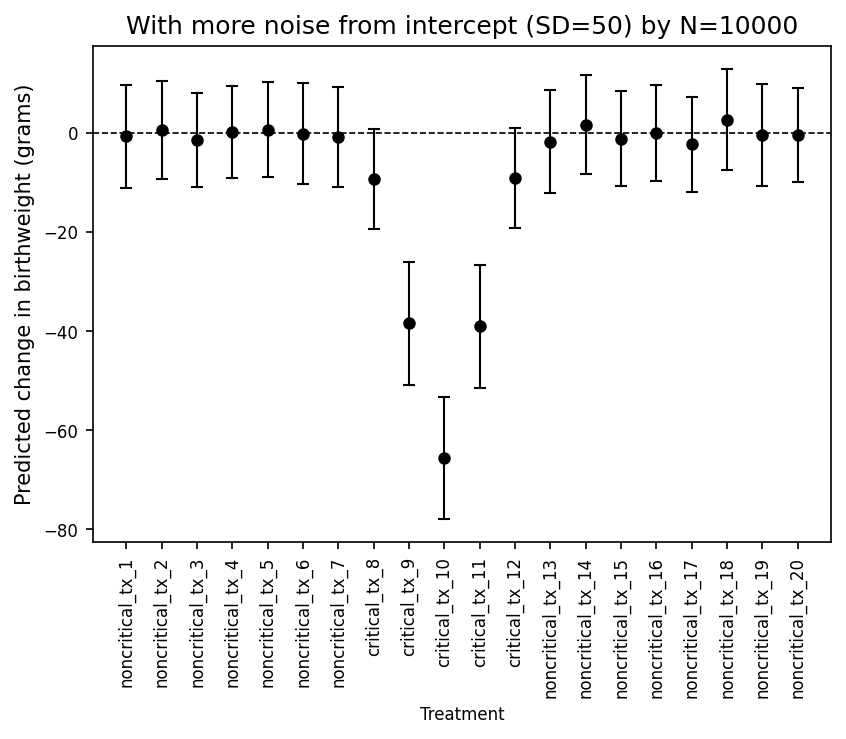

In [189]:
plt.figure(figsize=(6, 4), dpi=150)
# ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
ci = np.array([res_df['mean'] - res_df['ci_lower'], res_df['ci_upper'] - res_df['mean']])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
plt.xticks(rotation=90)
plt.title("With more noise from intercept (SD=50) by N=10000")
# plt.savefig('raw_forest_plot.png')
plt.show()

#### Model 1.B
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is naive, with equal (i.e., constant) effects  

##### "Data"

In [128]:
np.random.seed(1004)

n_samples = 5000

n_X = 1
n_T = 5 # one critical, one not
n_W = 1 # one confounder

# features (in this case, confounders); z-scaled
X = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
# treatments / exposures; z-scaled
T_sample = births.sample(n = 5000)

o3_sd = T_sample['max_o3_01'].std()

T_1 = T_sample['max_o3_01'] / o3_sd
T_2 = T_sample['max_o3_02'] / o3_sd
T_3 = T_sample['max_o3_03'] / o3_sd
T_4 = T_sample['max_o3_04'] / o3_sd
T_5 = T_sample['max_o3_05'] / o3_sd

Adjust the confounder so it is related to one treatment.

In [134]:
np.random.seed(1004)

## Confounder coefficient
# keeping equal for now
b_W0T1 = 0 # not critical, unconfounded
b_W0T2 = 2.5
b_W0T3 = 2.5
b_W0T4 = 2.5
b_W0T5 = 0 # not critical, unconfounded
X = b_W0T1 * T_1 + b_W0T2 * T_2 + b_W0T3 * T_3 + b_W0T4 * T_4 + b_W0T5 * T_5 + np.random.normal(size=n_samples) - 40
# a 2.5-unit increase in the confounder increases each exposure by 1 unit
# this is done backwards (tx causes confounder) because later on, we'll use a real tx and synthetic confounder

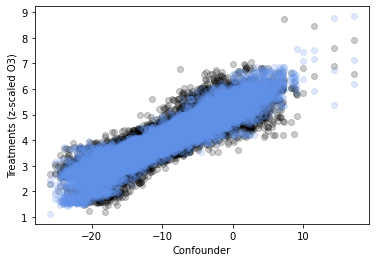

In [141]:
plt.plot(X, T_1, 'o', alpha = 0.2, color = "black") # unconfounded, noncritical tx in black
plt.plot(X, T_5, 'o', alpha = 0.2, color = "black") # unconfounded, noncritical tx in black
plt.plot(X, T_2, 'o', alpha = 0.2, color = "cornflowerblue") # confounded critical tx in blue
plt.plot(X, T_3, 'o', alpha = 0.2, color = "cornflowerblue") # confounded critical tx in blue
plt.plot(X, T_4, 'o', alpha = 0.2, color = "cornflowerblue") # confounded critical tx in blue
plt.xlabel("Confounder")
plt.ylabel("Treatments (z-scaled O3)")
plt.show()

Create the outcome

In [144]:
## Coefficients
b_int = bw_mean + 500 # bw_mean for baseline, plus enough to make the predicted mean = bw_mean
b_T2y = 0 # not critical, no effect
b_T2y = -70 # a one-sd increase in o3 decreases bw by 70 g
b_T3y = -70 # a one-sd increase in o3 decreases bw by 70 g
b_T4y = -70 # a one-sd increase in o3 decreases bw by 70 g
b_T5y = 0 # not critical, no effect
b_W0y = -35 # the confounder also decreases bw by 75 g per one-sd increase

y = b_int + b_T1y * T_1 + b_T2y * T_2 + b_T3y * T_3 + b_T4y * T_4 + b_T5y * T_5 + b_W0y * X

# bw_mean = births["birthweightgrams"].mean()
# bw_sd = births["birthweightgrams"].std()


3260.2554276717005
3275.0093262678606
536.5732455330558
443.0804080174326


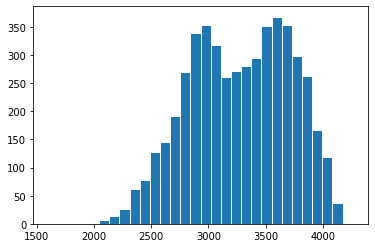

In [146]:
plt.hist(y, bins = 30, edgecolor = "white")
print(bw_mean)
print(y.mean()) # this is about right
print(bw_sd)
print(y.std()) # only a bit too small

Correlation between exposures, confounder, outcome

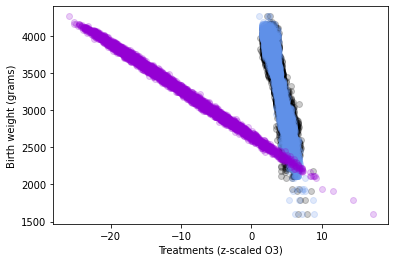

In [150]:
plt.plot(T_5, y, 'o', alpha = 0.2, color = "black") # unconfounded tx in black
plt.plot(T_1, y, 'o', alpha = 0.2, color = "black") # unconfounded tx in black
plt.plot(T_4, y, 'o', alpha = 0.2, color = "cornflowerblue") # unconfounded tx in blue
plt.plot(T_3, y, 'o', alpha = 0.2, color = "cornflowerblue") # unconfounded tx in blue
plt.plot(T_2, y, 'o', alpha = 0.2, color = "cornflowerblue") # unconfounded tx in blue
plt.plot(X, y, 'o', alpha = 0.2, color = "darkviolet") # confounder in green
plt.xlabel("Treatments (z-scaled O3)")
plt.ylabel("Birth weight (grams)")
plt.show()

Matrices for treatments, confounders, outcome

In [151]:
T = pd.DataFrame({'noncritical_tx_1': T_1, 'critical_tx_2': T_2,
                  'critical_tx_3': T_3, 'critical_tx_4': T_4,
                  'noncritical_tx_5': T_5})
X = pd.DataFrame(X, columns=['confounder'])

##### Causal RF

In [152]:
est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      n_estimators=500)
est.fit(y, T=T, X=X, W=X)
# note: it takes >100 times longer to run the causal RF over the linear model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/econml/utilities.py:644: UserWarning: Not all column names are strings. Coercing to strings for now.
  warnings.warn("Not all column names are strings. Coercing to strings for now.", UserWarning)


Extract the marginal effects

In [153]:
est.marginal_ate_inference(T, X)

In [154]:
res_list = []

for i in range(n_T):
    current_result = {
        'treatment': est.cate_treatment_names()[i],
        'mean': est.marginal_ate(T, X)[i],
        'ci_lower': est.marginal_ate_interval(T, X)[1][i],
        'ci_upper': est.marginal_ate_interval(T, X)[0][i]
    }

    # append to list
    res_list.append(current_result)

res_df = pd.DataFrame(res_list)
res_df


,treatment,mean,ci_lower,ci_upper
0,noncritical_tx_1,0.058398,2.045758,-1.928963
1,critical_tx_2,-70.224486,-65.868035,-74.580938
2,critical_tx_3,-70.369056,-65.935969,-74.802144
3,critical_tx_4,-70.105977,-65.734196,-74.477758
4,noncritical_tx_5,0.103901,2.329152,-2.121351


Plot the marginal effects

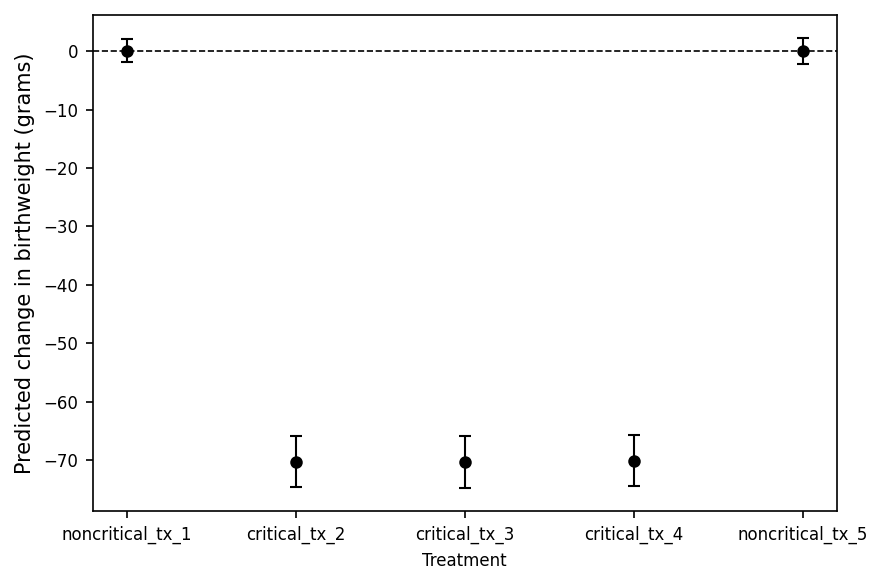

In [155]:
plt.figure(figsize=(6, 4), dpi=150)
ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

#### Model 1.C
- 6 exposures: 3 critical, 2 not critical, 1 confounder on critical exposures  
- CW is time-varying, with larger effects around a peak (e.g., high in weeks 2, 4; peak in week 3)  

##### "Data"

In [156]:
np.random.seed(1004)

n_samples = 5000

n_X = 1
n_T = 5 # one critical, one not
n_W = 1 # one confounder

# features (in this case, confounders); z-scaled
X = np.random.normal(size = n_samples, loc = o3_mean, scale = o3_sd) / o3_sd
# treatments / exposures; z-scaled
T_sample = births.sample(n = 5000)

o3_sd = T_sample['max_o3_01'].std()

T_1 = T_sample['max_o3_01'] / o3_sd
T_2 = T_sample['max_o3_02'] / o3_sd
T_3 = T_sample['max_o3_03'] / o3_sd
T_4 = T_sample['max_o3_04'] / o3_sd
T_5 = T_sample['max_o3_05'] / o3_sd

Adjust the confounder so it is related to one treatment.

In [157]:
np.random.seed(1004)

## Confounder coefficient
# b_W0T1 = 2.5 # not critical
b_W0T2 = 2.5
b_W0T3 = 2.5
b_W0T4 = 2.5
# b_W0T5 = 2.5 # not critical
X = b_W0T1 * T_2 + b_W0T3 * T_3 + b_W0T4 * T_4 + np.random.normal(size=n_samples) - 40
# a 0.5-unit increase in the confounder increases the exposure by 1 unit
# this is done backwards (tx causes confounder) because later on, we'll use a real tx and synthetic confounder

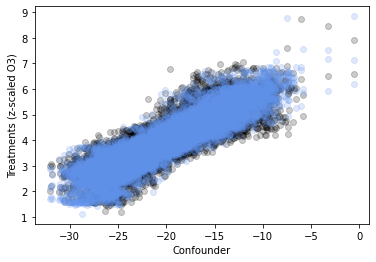

In [163]:
plt.plot(X, T_1, 'o', alpha = 0.2, color = "black") # unconfounded, noncritical tx in black
plt.plot(X, T_5, 'o', alpha = 0.2, color = "black") # unconfounded, noncritical tx in black
plt.plot(X, T_2, 'o', alpha = 0.2, color = "cornflowerblue") # confounded critical tx in blue
plt.plot(X, T_3, 'o', alpha = 0.2, color = "cornflowerblue") # confounded critical tx in blue
plt.plot(X, T_4, 'o', alpha = 0.2, color = "cornflowerblue") # confounded critical tx in blue
plt.xlabel("Confounder")
plt.ylabel("Treatments (z-scaled O3)")
plt.show()

Create the outcome

In [159]:
## Coefficients
b_int = bw_mean + 400 # bw_mean for baseline, plus enough to make the predicted mean = bw_mean
b_T2y = 0 # not critical, no effect
b_T2y = -60 # a one-sd increase in o3 decreases bw by 70 g
b_T3y = -90 # a one-sd increase in o3 decreases bw by 70 g
b_T4y = -60 # a one-sd increase in o3 decreases bw by 70 g
b_T5y = 0 # not critical, no effect
b_W0y = -35 # the confounder also decreases bw by 75 g per one-sd increase

y = b_int + b_T1y * T_1 + b_T2y * T_2 + b_T3y * T_3 + b_T4y * T_4 + b_T5y * T_5 + b_W0y * X

# bw_mean = births["birthweightgrams"].mean()
# bw_sd = births["birthweightgrams"].std()


3260.2554276717005
3523.4020973014094
536.5732455330558


362.8444775692011

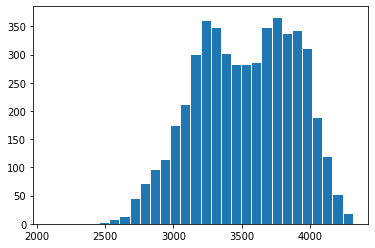

In [160]:
plt.hist(y, bins = 30, edgecolor = "white")
print(bw_mean)
print(y.mean()) # this is about right
print(bw_sd)
y.std() # this is too small ### will need to rectify this

Correlation between exposures, outcome, confounder

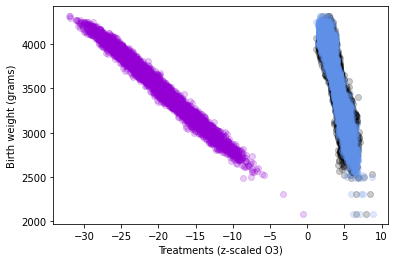

In [162]:
plt.plot(T_5, y, 'o', alpha = 0.2, color = "black") # unconfounded tx in black
plt.plot(T_1, y, 'o', alpha = 0.2, color = "black") # unconfounded tx in black
plt.plot(T_4, y, 'o', alpha = 0.2, color = "cornflowerblue") # unconfounded tx in blue
plt.plot(T_3, y, 'o', alpha = 0.2, color = "cornflowerblue") # unconfounded tx in blue
plt.plot(T_2, y, 'o', alpha = 0.2, color = "cornflowerblue") # unconfounded tx in blue
plt.plot(X, y, 'o', alpha = 0.2, color = "darkviolet") # confounder in green
plt.xlabel("Treatments (z-scaled O3)")
plt.ylabel("Birth weight (grams)")
plt.show()

Matrices for treatments, confounder, outcome

In [164]:
T = pd.DataFrame({'noncritical_tx_1': T_1, 'critical_tx_2': T_2,
                  'critical_tx_3': T_3, 'critical_tx_4': T_4,
                  'noncritical_tx_5': T_5})
X = pd.DataFrame(X, columns=['confounder'])

##### Causal RF

In [165]:
est = CausalForestDML(model_t='forest',
                      model_y='forest',
                      discrete_treatment=False,
                      n_estimators=500)
est.fit(y, T=T, X=X, W=X)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/econml/utilities.py:644: UserWarning: Not all column names are strings. Coercing to strings for now.
  warnings.warn("Not all column names are strings. Coercing to strings for now.", UserWarning)


Extract marginal effects

In [166]:
est.marginal_ate_inference(T, X)

In [167]:
res_list = []

for i in range(n_T):
    current_result = {
        'treatment': est.cate_treatment_names()[i],
        'mean': est.marginal_ate(T, X)[i],
        'ci_lower': est.marginal_ate_interval(T, X)[1][i],
        'ci_upper': est.marginal_ate_interval(T, X)[0][i]
    }

    # append to list
    res_list.append(current_result)

res_df = pd.DataFrame(res_list)
res_df


,treatment,mean,ci_lower,ci_upper
0,noncritical_tx_1,-0.086230,2.445992,-2.618452
1,critical_tx_2,-59.611615,-56.551777,-62.671454
2,critical_tx_3,-89.300908,-84.635856,-93.965961
3,critical_tx_4,-59.692081,-55.247619,-64.136543
4,noncritical_tx_5,0.002385,2.760084,-2.755314


Plot the marginal effects

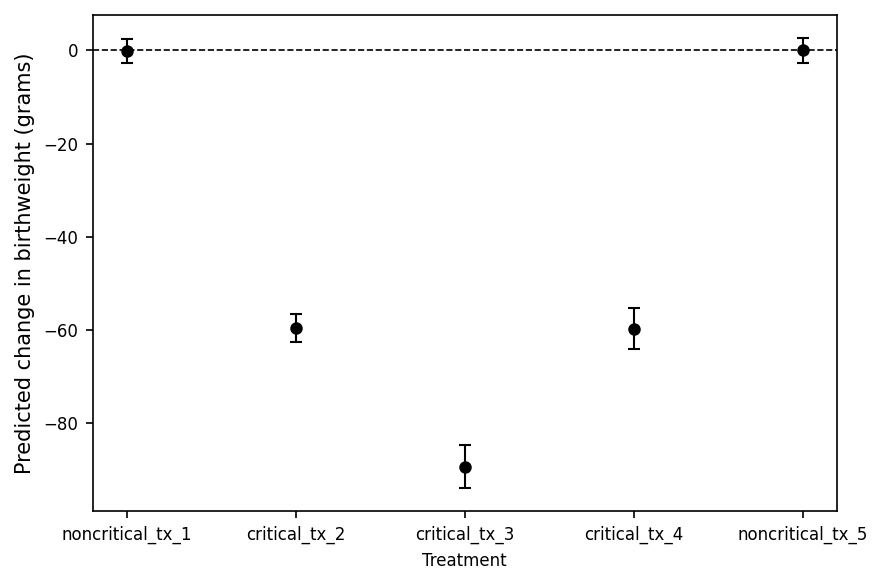

In [168]:
plt.figure(figsize=(6, 4), dpi=150)
ci = np.array([res_df['ci_lower'] - res_df['mean'], res_df['mean'] - res_df['ci_upper'] ])
plt.errorbar(y = res_df['mean'], 
             x = res_df['treatment'], 
            yerr = ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axhline(y=0, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Treatment', fontsize=8)
plt.ylabel('Predicted change in birthweight (grams)')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()